# Predict Average Bunker Score

Preidcts the average score for each bunker solely based on the sentiment analysis of the text in each review.

### 1. Imports

In [106]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


### 2: File paths

In [107]:
data_path = "../../data/processed/processed_bunker_sentiment.pkl"
model_path = "../outputs_final/bunker_multi_class/final_model"

### 3: Load and filter data

In [108]:
df = pd.read_pickle(data_path, )
bunker_counts = df["bunker_name"].value_counts()
valid_bunkers = bunker_counts[bunker_counts >= 100].index
df = df[df["bunker_name"].isin(valid_bunkers)].copy()
print(f"Filtered to {len(valid_bunkers)} bunkers with >= 100 reviews")

Filtered to 6 bunkers with >= 100 reviews


### 4: Load model and tokenizer

In [109]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")  # or "bert-base-cased"
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

# Detect device: prioritize MPS, fallback to CUDA, then CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model.to(device)
print(f"Using device: {device}")

Using device: mps


### 5. Prediction function

In [110]:
def predict_sentiment_batch(token_batch):
    input_ids = torch.tensor([x["input_ids"] for x in token_batch]).to(device)
    attention_mask = torch.tensor([x["attention_mask"] for x in token_batch]).to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)
    
    return preds.cpu().tolist()


### 6: Predict in batches

In [111]:
batch_size = 32
tokens = df["tokens"].tolist()
predictions = []

for i in tqdm(range(0, len(tokens), batch_size)):
    batch = tokens[i:i+batch_size]
    preds = predict_sentiment_batch(batch)
    predictions.extend(preds)

 25%|██▌       | 109/435 [15:14<45:35,  8.39s/it]  


KeyboardInterrupt: 

### 7. Add predictions to dataframe

In [ ]:
df["predicted_label"] = predictions
label_to_score = {0: -1, 1: 0, 2: 1}
df["sentiment_score"] = df["predicted_label"].map(label_to_score)

In [1]:
import gc
del tokens, batch, preds, predictions  # Delete if still in memory
gc.collect()


NameError: name 'tokens' is not defined

### 8. Aggregate scores per bunker

In [ ]:
bunker_scores = df.groupby("bunker_name")["sentiment_score"].mean().reset_index()
bunker_scores = bunker_scores.sort_values(by="sentiment_score", ascending=False)
bunker_scores.head()

,bunker_name,sentiment_score
0,betasom,0.798627
3,larochelle_museum,0.756854
1,hamburg,0.744902
2,keroman,0.735960
5,valentin,0.728178


### 9: Save results

In [ ]:
output_path = "../../data/processed/bunker_sentiment_ranking.csv"
bunker_scores.to_csv(output_path, index=False)
print(f"Saved bunker sentiment ranking to: {output_path}")

Saved bunker sentiment ranking to: ../../data/processed/bunker_sentiment_ranking.csv


### 10. Distribution of Average Sentiment Scores Across Bunkers

/var/folders/g6/rpqlqh_142q2yhdtrkhh5jnh0000gn/T/ipykernel_73330/3702938817.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=merged, x="bunker_name_formatted", y="normalized_sentiment", palette="coolwarm")
/var/folders/g6/rpqlqh_142q2yhdtrkhh5jnh0000gn/T/ipykernel_73330/3702938817.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
/var/folders/g6/rpqlqh_142q2yhdtrkhh5jnh0000gn/T/ipykernel_73330/3702938817.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{y:.1f}" for y in ax.get_yticks()], fontweight='bold')


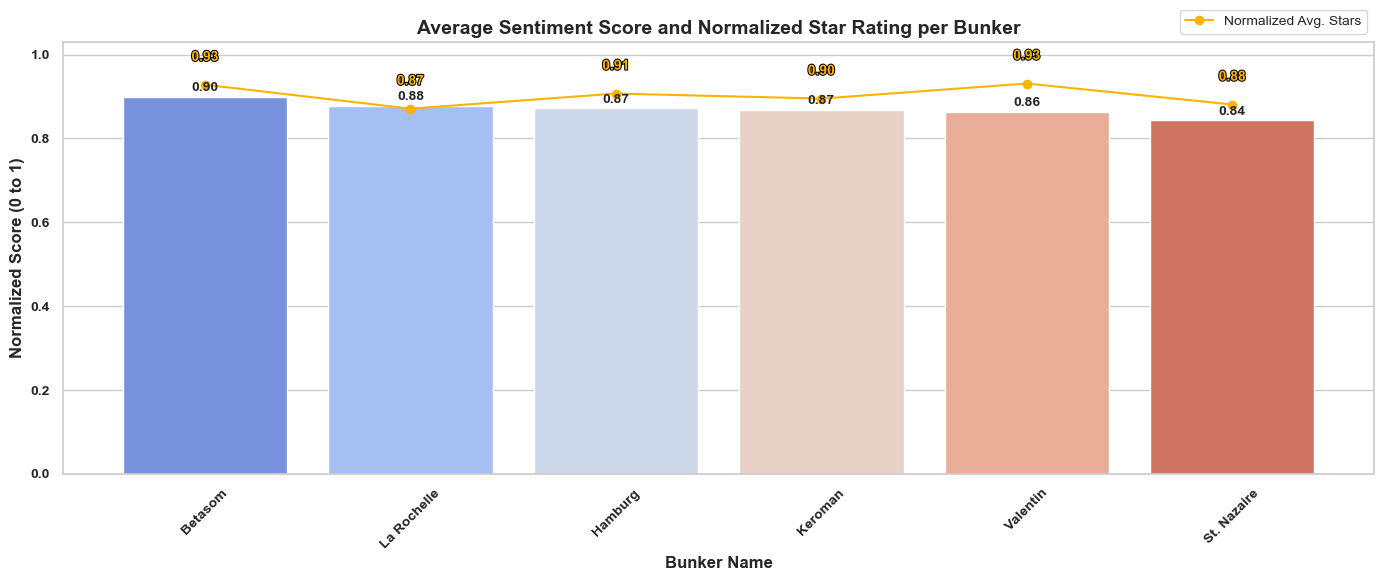

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects

# Compute average star ratings per bunker
star_scores = df.groupby("bunker_name")["stars"].mean().reset_index()

# Normalize stars to range 0–1 (assuming original is 1–5)
star_scores["normalized_stars"] = star_scores["stars"] / 5

# Merge sentiment and star scores
merged = pd.merge(bunker_scores, star_scores[["bunker_name", "normalized_stars"]], on="bunker_name")

# Normalize sentiment to 0–1 (from original -1 to 1)
merged["normalized_sentiment"] = (merged["sentiment_score"] + 1) / 2

# Format bunker names for display
merged["bunker_name_formatted"] = merged["bunker_name"].replace({
    "stnazaire": "St. Nazaire",
    "larochelle_museum": "La Rochelle",
    "keroman": "Keroman",
    "betasom": "Betasom",
    "hamburg": "Hamburg",
    "valentin": "Valentin",
})

# Set y-axis range
ymin = 0
ymax = max(merged["normalized_sentiment"].max(), merged["normalized_stars"].max()) + 0.1

# Create plot
plt.figure(figsize=(14, 6))
ax = sns.barplot(data=merged, x="bunker_name_formatted", y="normalized_sentiment", palette="coolwarm")

# Yellow line for normalized stars
line_color = "#FFB300"
x_positions = ax.get_xticks()
ax.plot(x_positions, merged["normalized_stars"], color=line_color, marker="o", linestyle='-', label="Normalized Avg. Stars")

# Annotate line values
for x, y in zip(x_positions, merged["normalized_stars"]):
    offset = 0.03 if y < 0.69 else 0.05
    txt = ax.text(
        x, y + offset, f"{y:.2f}",
        ha='center', va='bottom',
        fontsize=10, fontweight='bold',
        color=line_color
    )
    txt.set_path_effects([
        path_effects.Stroke(linewidth=1.5, foreground='black'),
        path_effects.Normal()
    ])

# Annotate bar values
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10, padding=2, fontweight='bold')

# Styling
plt.title("Average Sentiment Score and Normalized Star Rating per Bunker", fontsize=14, fontweight='bold')
ax.set_ylabel("Normalized Score (0 to 1)", fontsize=12, fontweight='bold')
ax.set_xlabel("Bunker Name", fontsize=12, fontweight='bold')
ax.set_ylim(ymin, ymax)

ax.tick_params(axis='x', labelrotation=45, labelsize=10)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
ax.tick_params(axis='y', labelsize=10)
ax.set_yticklabels([f"{y:.1f}" for y in ax.get_yticks()], fontweight='bold')

# Legend
ax.legend(loc="upper right", bbox_to_anchor=(1, 1.09), fontsize=10)

# Final layout
plt.tight_layout()

# Save high-res image for Overleaf
plt.savefig("/Users/askkvarven/Desktop/avg_bunker_score_wo_stars.png", dpi=300)


# Optional: Show plot in notebook (remove if only saving)
# plt.show()


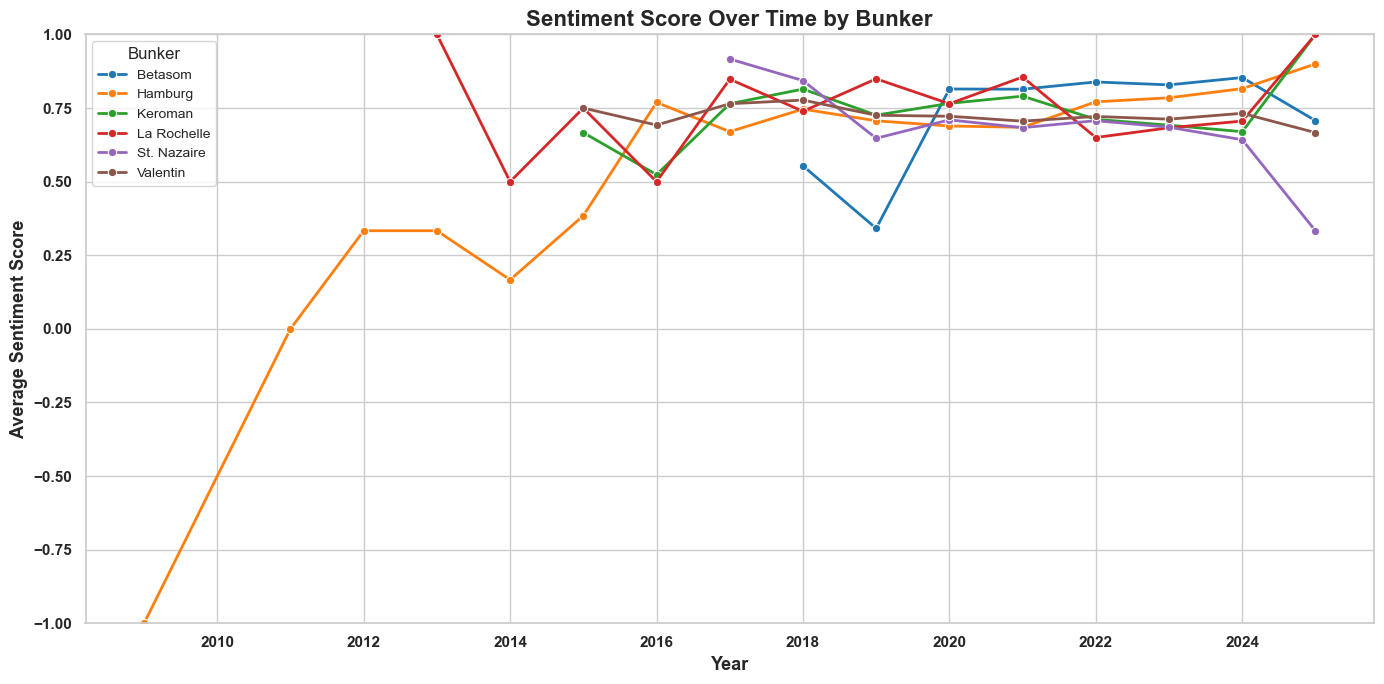

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by bunker and year, then calculate mean sentiment score
grouped = df.groupby(['bunker_name', 'year'])['sentiment_score'].mean().reset_index()

# Apply full name formatting
grouped["bunker_name_formatted"] = grouped["bunker_name"].replace({
    "stnazaire": "St. Nazaire",
    "larochelle_museum": "La Rochelle",
    "keroman": "Keroman",
    "betasom": "Betasom",
    "hamburg": "Hamburg",
    "valentin": "Valentin",
})

# Plot
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

# Lineplot with one line per bunker
ax = sns.lineplot(
    data=grouped,
    x="year",
    y="sentiment_score",
    hue="bunker_name_formatted",
    marker="o",
    linewidth=2,
    palette="tab10"
)

# Styling
plt.title("Sentiment Score Over Time by Bunker", fontsize=16, fontweight="bold")
plt.xlabel("Year", fontsize=13, fontweight="bold")
plt.ylabel("Average Sentiment Score", fontsize=13, fontweight="bold")
plt.xticks(fontsize=11, fontweight="bold")
plt.yticks(fontsize=11, fontweight="bold")
plt.legend(title="Bunker", title_fontsize=12, fontsize=10)
plt.ylim(-1, 1)  # Since sentiment scores are in the range -1 to 1
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by bunker and year, then calculate mean sentiment score
grouped = df.groupby(['bunker_name', 'year'])['sentiment_score'].mean().reset_index()

# Apply full name formatting
grouped["bunker_name_formatted"] = grouped["bunker_name"].replace({
    "stnazaire": "St. Nazaire",
    "betasom": "Betasom"
})

# Filter to only Betasom and St. Nazaire
filtered = grouped[grouped["bunker_name_formatted"].isin(["Betasom", "St. Nazaire"])]

# Plot
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

ax = sns.lineplot(
    data=filtered,
    x="year",
    y="sentiment_score",
    hue="bunker_name_formatted",
    marker="o",
    linewidth=2.5,
    palette=["#4575b4", "#d73027"]  # Optional: custom color for clarity
)

# Styling
plt.title("Sentiment Score Over Time: Betasom vs St. Nazaire", fontsize=16, fontweight="bold")
plt.xlabel("Year", fontsize=13, fontweight="bold")
plt.ylabel("Average Sentiment Score", fontsize=13, fontweight="bold")
plt.xticks(fontsize=11, fontweight="bold")
plt.yticks(fontsize=11, fontweight="bold")
plt.legend(title="Bunker", title_fontsize=12, fontsize=10)
plt.ylim(-1, 1)  # Sentiment score range
plt.tight_layout()
plt.show()


KeyError: 'Column not found: sentiment_score'

In [ ]:
import pandas as pd
import re

# --- Reload full dataset to include all bunkers ---
df = pd.read_pickle(data_path)  # Make sure this points to your full dataset

# Extended keyword list
keywords = [
    # Structural
    "crack", "cracked", "cracks", "fracture", "fractured", "fractures",
    "damage", "damaged", "damages", "ruin", "ruined", "ruins",
    "degrade", "degraded", "degrading", "deteriorate", "deteriorated", "deteriorating",
    "broken", "crumbling", "collapse", "collapsed", "disintegration", "disintegrated",
    "wear", "worn", "eroded", "erosion", "weathered", "weathering",
    "unstable", "unsafe", "risky", "dangerous", "sagging", "tilting", "leaning", "falling apart",

    # Biological
    "moss", "mould", "mold", "mildew", "lichen", "lichens", "algae", "fungi",
    "vegetation", "overgrown", "undergrowth", "plants", "biological proliferation", "nature taking over", "wild growth",

    # Moisture
    "humidity", "moist", "moisture", "damp", "wet", "leaking", "leak", "leakage",
    "seep", "seepage", "water infiltration", "water damage", "condensation", "stains", "staining", "watermarks",

    # Chemical
    "corrosion", "corroded", "corroding", "rust", "rusty", "rusting", "oxidation", "oxidized", "oxidising",
    "carbonation", "efflorescence", "salt", "salts", "patina", "discoloration", "discolouration",

    # Neglect
    "aging", "aged", "old", "ancient", "neglected", "abandonment", "abandoned",
    "decay", "decayed", "decaying", "derelict", "dilapidated", "decrepit", "rundown", "forgotten", "worn out", "obsolete"
]

# Compile regex pattern
escaped_keywords = [re.escape(word) for word in keywords]
pattern = re.compile(r"|".join(escaped_keywords), re.IGNORECASE)

# Match function
def keyword_match(text):
    return bool(pattern.search(str(text)))  # Robust against NaNs

# Apply keyword matching
df["keyword_mention"] = df["clean_text"].apply(keyword_match)

# Compute keyword stats per bunker
bunker_keyword_stats = (
    df.groupby("bunker_name")["keyword_mention"]
    .agg([("mention_count", "sum"), ("total_reviews", "count")])
    .assign(percentage=lambda x: (x["mention_count"] / x["total_reviews"] * 100).round(2))
    .reset_index()
    .sort_values(by="percentage", ascending=False)
)

# Show result
print(bunker_keyword_stats)


          bunker_name  mention_count  total_reviews  percentage
1               bruno              1              6       16.67
3               dora2              3             19       15.79
2               dora1              6             46       13.04
5               fink2              7             54       12.96
9   larochelle_museum            111           1386        8.01
6             hamburg            345           4806        7.18
8             keroman             61           1193        5.11
0             betasom            176           3496        5.03
11           valentin             83           1707        4.86
10          stnazaire             58           1323        4.38
7            hornisse              2             89        2.25
4               elbe2              0              2        0.00


In [ ]:
import pandas as pd
import re

# --- Load full dataset (override any previous filtering) ---
df = pd.read_pickle(data_path)  # Ensure this path points to your complete dataset

# Experience-related keywords
experience_keywords = [
    # Positive emotional tone
    "amazing", "incredible", "fantastic", "impressive", "beautiful", "breathtaking", 
    "moving", "touching", "memorable", "fascinating", "worth", "worthwhile", 
    "recommend", "recommended", "recommendation", "enjoy", "enjoyed", "enjoyable",
    "interesting", "well done", "insightful", "educational", "authentic", "immersive",

    # Guided experiences
    "guide", "guided", "tour", "tours", "touring", "informative", "narrative", 
    "presentation", "explanation", "exhibit", "exhibits", "exhibition", "museum",

    # Atmosphere/setting
    "atmosphere", "ambience", "setting", "layout", "lighting", "sound", "audioguide",
    "interactive", "display", "displays", "organized", "organization", "clean", "accessible",

    # Engagement/Facilities
    "children", "family", "engaging", "hands-on", "staff", "friendly", "helpful", "service",
    "welcome", "welcoming", "ticket", "booking", "shop", "cafe", "accessibility", "signage"
]

# Escape and compile regex
escaped_keywords = [re.escape(word) for word in experience_keywords]
experience_pattern = re.compile(r"|".join(escaped_keywords), re.IGNORECASE)

# Apply keyword matching
df["experience_mention"] = df["clean_text"].apply(lambda x: bool(experience_pattern.search(str(x))))

# Compute keyword stats per bunker
experience_stats = (
    df.groupby("bunker_name")["experience_mention"]
    .agg([("mention_count", "sum"), ("total_reviews", "count")])
    .assign(percentage=lambda x: (x["mention_count"] / x["total_reviews"] * 100).round(2))
    .reset_index()
    .sort_values(by="percentage", ascending=False)
)

# Display result
print(experience_stats)


          bunker_name  mention_count  total_reviews  percentage
6             hamburg           3683           4806       76.63
9   larochelle_museum            951           1386       68.61
11           valentin           1142           1707       66.90
8             keroman            743           1193       62.28
0             betasom           2132           3496       60.98
7            hornisse             48             89       53.93
10          stnazaire            662           1323       50.04
1               bruno              3              6       50.00
4               elbe2              1              2       50.00
5               fink2             26             54       48.15
2               dora1             16             46       34.78
3               dora2              6             19       31.58


In [ ]:
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
import nltk
import re

# Ensure stopwords are available
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Load full dataset
df = pd.read_pickle(data_path)  # Replace with your actual path

def analyze_bunker_yearly_keywords(bunker_name, display_name):
    print(f"\n{'='*10} {display_name} {'='*10}")
    bunker_df = df[df["bunker_name"] == bunker_name].copy()

    for year in sorted(bunker_df["year"].unique()):
        year_df = bunker_df[bunker_df["year"] == year]
        texts = year_df["clean_text"].dropna().astype(str)

        # Tokenize and filter
        tokens = []
        for text in texts:
            words = re.findall(r'\b\w+\b', text.lower())
            words = [w for w in words if w not in stop_words and len(w) > 2]
            tokens.extend(words)

        most_common = Counter(tokens).most_common(5)

        # Print result
        print(f"\nYear: {year}")
        print(f"Number of reviews: {len(year_df)}")
        print("Top 5 words:")
        for word, count in most_common:
            print(f"  {word}: {count}")

# Run analysis for both bunkers
analyze_bunker_yearly_keywords("stnazaire", "St. Nazaire")
analyze_bunker_yearly_keywords("betasom", "Betasom")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/askkvarven/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



========== St. Nazaire ==========

Year: 2017
Number of reviews: 12
Top 5 words:
  interesting: 4
  submarine: 4
  war: 3
  free: 3
  visit: 3

Year: 2018
Number of reviews: 83
Top 5 words:
  visit: 26
  beautiful: 13
  interesting: 12
  submarine: 12
  base: 11

Year: 2019
Number of reviews: 346
Top 5 words:
  place: 85
  visit: 71
  see: 52
  submarine: 50
  interesting: 49

Year: 2020
Number of reviews: 131
Top 5 words:
  place: 37
  visit: 32
  interesting: 21
  nice: 16
  see: 16

Year: 2021
Number of reviews: 199
Top 5 words:
  visit: 40
  place: 39
  submarine: 27
  good: 21
  interesting: 20

Year: 2022
Number of reviews: 181
Top 5 words:
  place: 41
  visit: 33
  great: 26
  impressive: 21
  interesting: 19

Year: 2023
Number of reviews: 200
Top 5 words:
  visit: 65
  place: 45
  submarine: 35
  see: 28
  history: 26

Year: 2024
Number of reviews: 165
Top 5 words:
  place: 48
  visit: 37
  submarine: 31
  interesting: 30
  base: 25

Year: 2025
Number of reviews: 6
Top 5 words

In [ ]:
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords

def most_common_negative_words(bunker_name, display_name, top_n=10):
    stop_words = set(stopwords.words("english"))

    # Filter negative reviews for the given bunker
    bunker_df = df[(df["bunker_name"] == bunker_name) & (df["sentiment_score"] < 0)]

    # Tokenize and clean
    all_tokens = []
    for text in bunker_df["clean_text"].dropna().astype(str):
        words = [w.lower() for w in text.split() if w.lower() not in stop_words]
        all_tokens.extend(words)

    word_counts = Counter(all_tokens)
    most_common = word_counts.most_common(top_n)

    print(f"\nTop {top_n} words in negative reviews for {display_name}:")
    for word, count in most_common:
        print(f"{word}: {count}")




KeyError: 'sentiment_score'